# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

import evidently
import shap

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics, preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

In [2]:
# load cleaned data
app_train = pd.read_pickle("../data/processed/app_train_cleaned.pkl")
app_test = pd.read_pickle(
    "../data/processed/app_test_cleaned.pkl"
)  # used for datadrift only

In [3]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 244 entries, SK_ID_CURR to FE_PAYMENT_RATE
dtypes: bool(130), float64(71), int64(43)
memory usage: 305.6 MB


# Split train/test
To keep some test data not seen by gridsearch

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    app_train.drop("TARGET", axis=1), app_train.TARGET, test_size=0.15
)

## Naive undersampler to fix target imbalance

In [5]:
def NaiveUnderSampler(df):
    # find the minority class
    min_class = df.TARGET.value_counts().idxmin()
    # keep same number of majority class than minority
    target_minority_count = df[df.TARGET == min_class].shape[0]
    df_balanced = pd.concat(
        [
            df[df.TARGET == min_class].sample(target_minority_count),
            df[df.TARGET != min_class].sample(target_minority_count),
        ]
    )
    # shuffle rows
    return df_balanced.sample(frac=1)

In [6]:
# create transformer with fit methods from my function
NaiveUnderSamplerTf = FunctionTransformer(NaiveUnderSampler)

In [7]:
# test naive imbalance fixer
app_train.pipe(NaiveUnderSampler).TARGET.value_counts()

TARGET
1    24825
0    24825
Name: count, dtype: int64

# Pipeline

In [8]:
# separate target
# X, y = app_train.drop("TARGET", axis=1), app_train.TARGET
# print(X.shape)
# print(y.shape)

In [9]:
samplerList = [NaiveUnderSamplerTf, RandomUnderSampler()]
pipe = Pipeline(
    [
        ("sampler", RandomUnderSampler()),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(max_iter=500)),
    ]
)
pipe

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [10]:
grid = GridSearchCV(pipe, param_grid={}, cv=3, n_jobs=-1, verbose=3, scoring="roc_auc")
grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1, param_grid={}, scoring='roc_auc', verbose=3)

In [11]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.992577,0.068057,0.540664,0.028335,{},0.744616,0.746654,0.741896,0.744389,0.001949,1


In [12]:
y_pred = grid.predict(X_test)

In [13]:
y_pred.shape

(46127,)

In [14]:
X_train.shape

(261384, 243)

# Proba predict treshold

In [15]:
# faire varier seuil et afficher graphiquement resultats

In [16]:
# # Make the model with the specified regularization parameter
# log_reg = LogisticRegression(max_iter=500)
# dummy = DummyClassifier()

# # Train on the training data
# log_reg.fit(X_train, y_train)
# # dummy.fit(X_train, y_train)

In [17]:
# y_pred = log_reg.predict(X_test)

In [18]:
# y_pred

# Scoring metric

In [19]:
y_pred.mean()

0.3481691850759859

In [20]:
metrics.accuracy_score(y_test, y_pred)

0.6822685195221887

Sensibilité : 1.00
Spécificité : 0.00
Seuil : 0.00


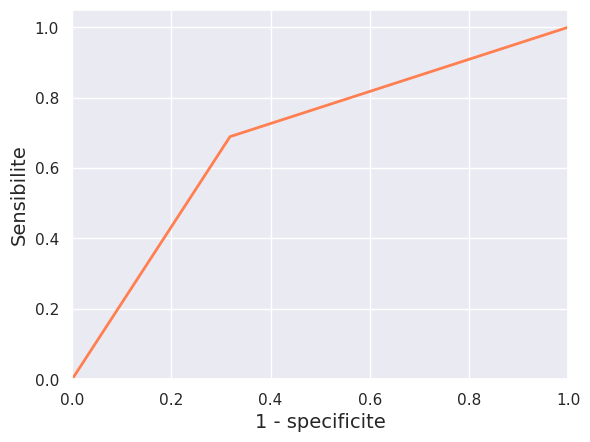

In [21]:
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95))

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1 - fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

# Profits and Loss function

In [22]:
def human_format(num):
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "{:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )

In [27]:
# compute mean ratio of value of goods, and amount loaned for buying this goods
GOODS_CREDIT_RATIO = (
    app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_GOODS_PRICE
    / app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_CREDIT
).mean()


def pnl(y_pred, y_true, interest=0.04, goods_recover_rate=0.60):
    # ajouter type casting
    # todo X en param
    # df.apply(pnl)
    # y_proba
    # interest  et GOODS_P en param
    # interest = 0.04
    # goods_recover_rate = 0.60
    credit = app_train.loc[X_test.index, "AMT_CREDIT"]
    # when goods value is missing, use 90% of credit amount
    seized_goods = (
        np.where(
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"].notna(),
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"],
            app_train.loc[X_test.index, "AMT_CREDIT"] * GOODS_CREDIT_RATIO,
        )
        * goods_recover_rate
    )
    pnl = pd.Series(np.nan)
    # TP : pret refusé correctement = pas de perte
    pnl = np.where((y_pred == 1) & (y_true == 1), 0, pnl)
    # FP : pret refusé par erreur : perte des interets
    pnl = np.where(
        (y_pred == 1) & (y_true == 0),
        -credit * interest,
        pnl,
    )
    # TN : pret accordé correctement : gain des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 0),
        credit * interest,
        pnl,
    )
    # FN : pret accordé par erreur : perte du montant du pret et des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 1),
        -credit * (1 + interest) + seized_goods,
        pnl,
    )
    return pnl.sum()

In [28]:
print("P&L avec prédictions modèle : $", human_format(pnl(y_pred, y_test)))
print("P&L avec prédictions parfaites : $", human_format(pnl(y_test, y_test)))

P&L avec prédictions modèle : $ 66.3M
P&L avec prédictions parfaites : $ 1.02B


In [29]:
y_pred.mean()

0.3481691850759859

In [30]:
y_test.mean()

0.08043011685130184

## Essai non concluant : calculer intérêts et durée du prêt en fonction du montant total et de l'annuity

In [31]:
app_train[["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]].sample(10)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
13472,540000.0,27000.0,540000.0
58974,773680.5,37350.0,679500.0
197511,888840.0,37494.0,675000.0
107683,225000.0,14647.5,225000.0
201356,95940.0,10201.5,90000.0
215121,416052.0,15075.0,292500.0
58304,765000.0,38250.0,765000.0
278228,900000.0,29164.5,900000.0
152143,1258650.0,53455.5,1125000.0
67646,622413.0,31909.5,495000.0


In [32]:
(app_train.AMT_ANNUITY / app_train.AMT_CREDIT).describe()

# app_train.AMT_CREDIT * 1.0665 / app_train.AMT_ANNUITY

count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
dtype: float64

# Shap values

In [33]:
explainer = shap.LinearExplainer(grid.best_estimator_["classifier"], X_train)
shap_values = explainer.shap_values(X_test)
shap_values

array([[-610.5772768959697, 0.007852400608566486, -0.12688650514680874,
        ..., 9377.949573916729, -0.06523968770676268,
        0.007464305278239496],
       [3253.870111910917, 0.007852400608566486, -0.12688650514680874,
        ..., -22829.557186586397, -0.013326560560389333,
        0.01574272645305564],
       [1227.017255492287, 0.007852400608566486, -0.12688650514680874,
        ..., 8457.735095045211, 0.09184337339392318,
        0.011841699039211683],
       ...,
       [4862.041375481141, 0.007852400608566486, 0.05437993077720375,
        ..., 4776.877179559139, -0.047973529257211406,
        0.01820930322997989],
       [-2285.634905566193, 0.007852400608566486, 0.05437993077720375,
        ..., -27430.629580943987, 0.3685242688970681,
        -0.03809723411584251],
       [1893.2860578255847, -0.1043247509423833, 0.05437993077720375,
        ..., -22829.557186586397, -0.0933112752326175,
        0.003410874308610267]], dtype=object)

In [34]:
X_test.shape

(46127, 243)

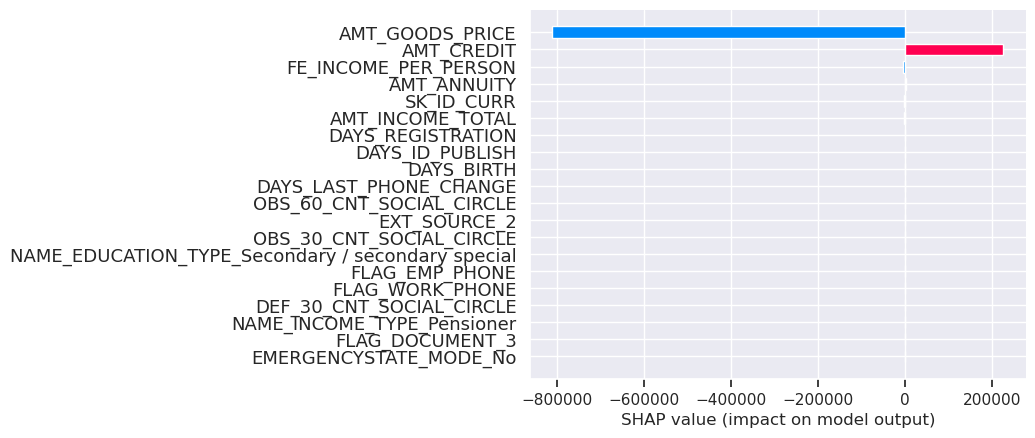

In [35]:
# explainer for only 1 sample row
shap.bar_plot(
    explainer.shap_values(X_test.sample(1))[0],
    feature_names=X_test.columns,
    max_display=20,
)

In [36]:
# shap.plots.beeswarm(explainer.shap_values(X_test))

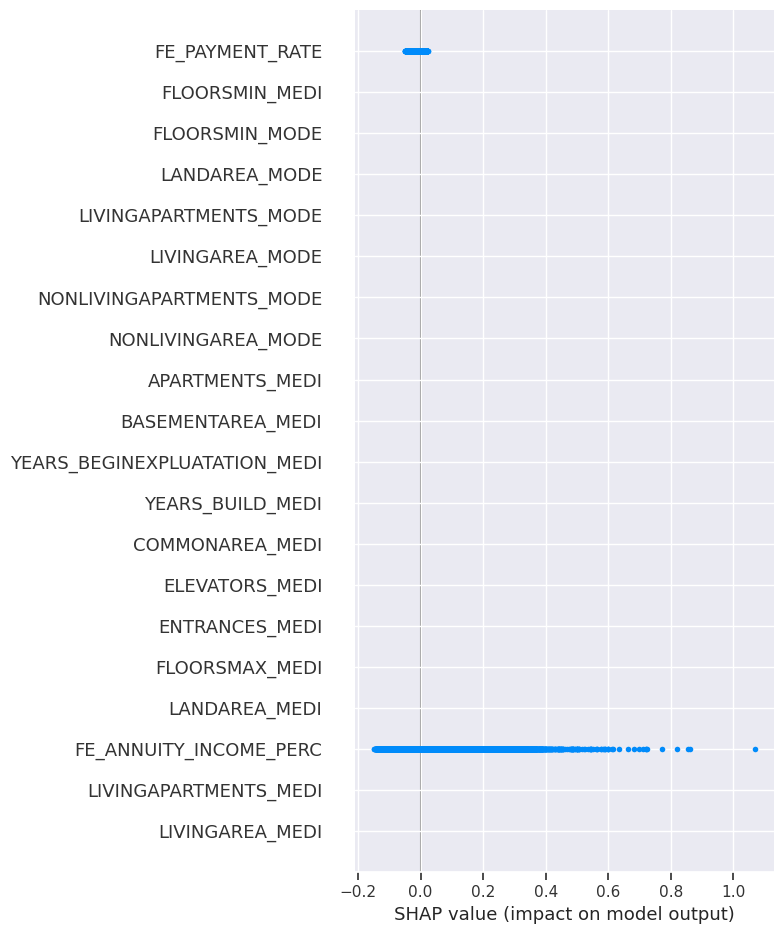

In [37]:
shap.summary_plot(
    explainer.shap_values(X_test).astype(float),
    feature_names=X_test.columns,
    # use_log_scale=True,
)

# Data Drift
Pour simuler évolution des commportements utilisateurs dans le temps, on fait l'hypothèse que `app_train` représente les données d'entrainement et `app_test` les données de test.  
On applique le même nettoyage à train et test

In [ ]:
from evidently.metric_preset import DataDriftPreset
from evidently.report import Report

data_drift_report = Report(
    metrics=[
        DataDriftPreset(),
    ]
)

data_drift_report.run(
    reference_data=app_train.sample(frac=0.05).drop("TARGET", axis=1),
    current_data=app_test.sample(frac=0.05),
    # column_mapping=None,
)

data_drift_report.save_html("../reports/data_drift_report.html")

In [ ]:
! firefox ../reports/data_drift_report.html

# Save trained model


## API tests

In [ ]:
customers = app_train.set_index("SK_ID_CURR")

In [ ]:
customers.head(10).index

In [ ]:
customers.head()

In [ ]:
customers.loc[100003, "AMT_INCOME_TOTAL"]  # .to_dict()

In [ ]:
customers.describe().loc[["count", "mean", "std"], :].to_dict()